In [1]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

#from albumentations.pytorch import ToTensor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from AlbumentationTransforms import AlbumentationTransform
from dataloader import getDataLoader
from models import resnet18
#import train

In [4]:
if(torch.cuda.is_available):
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
import albumentations as AL
import albumentations.pytorch as AT

In [6]:
train_transform = AlbumentationTransform([
                                       AL.RandomCrop(32, 32),
                                       AL.Rotate((-30.0, 30.0)),
                                       AL.HorizontalFlip(p=0.5),
                                       AL.RandomBrightness(),
                                       AL.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                       AL.Cutout(num_holes=1, max_h_size=16, max_w_size = 16, p=1),
                                       AT.ToTensor()
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransform([AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), AT.ToTensor()])

In [7]:
trainloader, testloader = getDataLoader('CIFAR10', 32, train_transform, test_transform)

Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

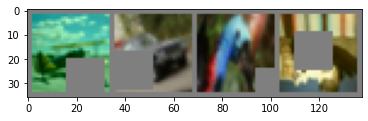

plane   car  bird   cat


In [11]:
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

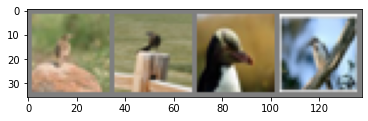

 bird  bird  bird  bird


In [13]:
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
net = resnet18.ResNet18()

In [15]:
net = net.to(device)

In [16]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [17]:
from lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



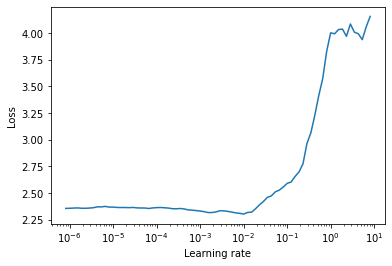

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7,  momentum = 0.9)#weight_decay=1e-2)
lr_finder = LRFinder(net, optimizer, criterion, device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)#, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [19]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)#, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [20]:
from tqdm import tqdm
import train_new
import test

tr_acc = []
tr_loss = []

te_acc = []
te_loss = []

pbar = tqdm(trainloader)

for epoch in range(50):

  train_accuracy, train_loss = train_new.cifar10train(net, device, trainloader, optimizer, criterion, pbar)
  tr_acc.append(train_accuracy)
  tr_loss.append(train_loss)

  test_accuracy, test_loss = test.cifar10test(net, device, testloader, criterion)
  te_acc.append(test_accuracy)
  te_loss.append(test_loss)
  scheduler.step(test_loss)

  print('Epoch {} completed'.format(epoch+1))
  



loss=1.7437310218811035 batch_id=1562 Accuracy = 38.34:   0%|          | 0/1563 [00:58<?, ?it/s]


Train set: Average loss: 0.0532, Accuracy: 19171/50000 (38.34%)
Test set: Average loss:  0.040185374116897585  Accurcy:  54.12
Epoch 1 completed


loss=1.3943729400634766 batch_id=1562 Accuracy = 55.52:   0%|          | 0/1563 [02:01<?, ?it/s]


Train set: Average loss: 0.0391, Accuracy: 27762/50000 (55.52%)
Test set: Average loss:  0.030090298843383788  Accurcy:  66.78
Epoch 2 completed


loss=1.1020338535308838 batch_id=1562 Accuracy = 63.26:   0%|          | 0/1563 [03:04<?, ?it/s]


Train set: Average loss: 0.0326, Accuracy: 31629/50000 (63.26%)
Test set: Average loss:  0.02514481702744961  Accurcy:  71.95
Epoch 3 completed


loss=0.6049574613571167 batch_id=1562 Accuracy = 68.14:   0%|          | 0/1563 [04:07<?, ?it/s]


Train set: Average loss: 0.0287, Accuracy: 34068/50000 (68.14%)
Test set: Average loss:  0.02104580971300602  Accurcy:  76.71
Epoch 4 completed


loss=0.4556567370891571 batch_id=1562 Accuracy = 71.06:   0%|          | 0/1563 [05:09<?, ?it/s]


Train set: Average loss: 0.0260, Accuracy: 35532/50000 (71.06%)
Test set: Average loss:  0.01808812892138958  Accurcy:  80.1
Epoch 5 completed


loss=0.5614175200462341 batch_id=1562 Accuracy = 72.99:   0%|          | 0/1563 [06:12<?, ?it/s]


Train set: Average loss: 0.0242, Accuracy: 36493/50000 (72.99%)
Test set: Average loss:  0.019335385963320732  Accurcy:  79.42
Epoch 6 completed


loss=0.967806339263916 batch_id=1562 Accuracy = 75.02:   0%|          | 0/1563 [07:15<?, ?it/s] 


Train set: Average loss: 0.0225, Accuracy: 37510/50000 (75.02%)
Test set: Average loss:  0.016368513695895672  Accurcy:  82.46
Epoch 7 completed


loss=1.0063574314117432 batch_id=1562 Accuracy = 76.46:   0%|          | 0/1563 [08:17<?, ?it/s]


Train set: Average loss: 0.0213, Accuracy: 38229/50000 (76.46%)
Test set: Average loss:  0.01632515689879656  Accurcy:  82.43
Epoch 8 completed


loss=0.6082170605659485 batch_id=1562 Accuracy = 78.01:   0%|          | 0/1563 [09:20<?, ?it/s]


Train set: Average loss: 0.0198, Accuracy: 39006/50000 (78.01%)
Test set: Average loss:  0.01435845431610942  Accurcy:  84.35
Epoch 9 completed


loss=1.0028597116470337 batch_id=1562 Accuracy = 78.99:   0%|          | 0/1563 [10:22<?, ?it/s] 


Train set: Average loss: 0.0189, Accuracy: 39493/50000 (78.99%)
Test set: Average loss:  0.014496932821720838  Accurcy:  84.33
Epoch 10 completed


loss=1.1180126667022705 batch_id=1562 Accuracy = 79.84:   0%|          | 0/1563 [11:24<?, ?it/s]


Train set: Average loss: 0.0181, Accuracy: 39920/50000 (79.84%)
Test set: Average loss:  0.014138831922411919  Accurcy:  84.64
Epoch 11 completed


loss=0.5451264381408691 batch_id=1562 Accuracy = 80.93:   0%|          | 0/1563 [12:26<?, ?it/s]


Train set: Average loss: 0.0171, Accuracy: 40466/50000 (80.93%)
Test set: Average loss:  0.01322210052460432  Accurcy:  85.9
Epoch 12 completed


loss=0.5716294050216675 batch_id=1562 Accuracy = 81.77:   0%|          | 0/1563 [13:29<?, ?it/s] 


Train set: Average loss: 0.0164, Accuracy: 40885/50000 (81.77%)
Test set: Average loss:  0.01196823068857193  Accurcy:  87.1
Epoch 13 completed


loss=0.44402310252189636 batch_id=1562 Accuracy = 82.67:   0%|          | 0/1563 [14:31<?, ?it/s]


Train set: Average loss: 0.0157, Accuracy: 41335/50000 (82.67%)
Test set: Average loss:  0.012060074544698  Accurcy:  87.49
Epoch 14 completed


loss=1.0684388875961304 batch_id=1562 Accuracy = 83.32:   0%|          | 0/1563 [15:32<?, ?it/s]


Train set: Average loss: 0.0151, Accuracy: 41658/50000 (83.32%)
Test set: Average loss:  0.012029138917475939  Accurcy:  87.48
Epoch 15 completed


loss=0.5266009569168091 batch_id=1562 Accuracy = 83.85:   0%|          | 0/1563 [16:34<?, ?it/s]


Train set: Average loss: 0.0144, Accuracy: 41927/50000 (83.85%)
Test set: Average loss:  0.011840178687870502  Accurcy:  87.75
Epoch 16 completed


loss=0.25885000824928284 batch_id=1562 Accuracy = 84.46:   0%|          | 0/1563 [17:36<?, ?it/s]


Train set: Average loss: 0.0141, Accuracy: 42228/50000 (84.46%)
Test set: Average loss:  0.012052660892158746  Accurcy:  87.38
Epoch 17 completed


loss=0.5746159553527832 batch_id=1562 Accuracy = 84.95:   0%|          | 0/1563 [18:38<?, ?it/s]


Train set: Average loss: 0.0135, Accuracy: 42475/50000 (84.95%)
Test set: Average loss:  0.010596929614245892  Accurcy:  88.49
Epoch 18 completed


loss=0.5537490844726562 batch_id=1562 Accuracy = 85.55:   0%|          | 0/1563 [19:39<?, ?it/s]


Train set: Average loss: 0.0130, Accuracy: 42777/50000 (85.55%)
Test set: Average loss:  0.010979118256270886  Accurcy:  88.1
Epoch 19 completed


loss=0.39931702613830566 batch_id=1562 Accuracy = 85.87:   0%|          | 0/1563 [20:40<?, ?it/s]


Train set: Average loss: 0.0127, Accuracy: 42936/50000 (85.87%)
Test set: Average loss:  0.010424062565714121  Accurcy:  89.17
Epoch 20 completed


loss=0.4087301194667816 batch_id=1562 Accuracy = 86.41:   0%|          | 0/1563 [21:41<?, ?it/s] 


Train set: Average loss: 0.0122, Accuracy: 43207/50000 (86.41%)
Test set: Average loss:  0.009992511545121669  Accurcy:  89.6
Epoch 21 completed


loss=0.4860879182815552 batch_id=1562 Accuracy = 86.86:   0%|          | 0/1563 [22:43<?, ?it/s]


Train set: Average loss: 0.0118, Accuracy: 43432/50000 (86.86%)
Test set: Average loss:  0.01067800674661994  Accurcy:  89.43
Epoch 22 completed


loss=0.21615664660930634 batch_id=1562 Accuracy = 87.07:   0%|          | 0/1563 [23:44<?, ?it/s]


Train set: Average loss: 0.0115, Accuracy: 43534/50000 (87.07%)
Test set: Average loss:  0.01051414838656783  Accurcy:  89.26
Epoch 23 completed


loss=0.7413777112960815 batch_id=1562 Accuracy = 87.61:   0%|          | 0/1563 [24:44<?, ?it/s]


Train set: Average loss: 0.0110, Accuracy: 43804/50000 (87.61%)
Test set: Average loss:  0.009495787906646729  Accurcy:  90.2
Epoch 24 completed


loss=0.1421063244342804 batch_id=1562 Accuracy = 87.92:   0%|          | 0/1563 [25:45<?, ?it/s] 


Train set: Average loss: 0.0108, Accuracy: 43962/50000 (87.92%)
Test set: Average loss:  0.009708747931569815  Accurcy:  89.71
Epoch 25 completed


loss=0.3733668327331543 batch_id=1562 Accuracy = 88.27:   0%|          | 0/1563 [26:46<?, ?it/s] 


Train set: Average loss: 0.0105, Accuracy: 44137/50000 (88.27%)
Test set: Average loss:  0.009437040069699287  Accurcy:  90.45
Epoch 26 completed


loss=0.4211946129798889 batch_id=1562 Accuracy = 88.72:   0%|          | 0/1563 [27:48<?, ?it/s] 


Train set: Average loss: 0.0102, Accuracy: 44358/50000 (88.72%)
Test set: Average loss:  0.009444996605068446  Accurcy:  90.27
Epoch 27 completed


loss=0.47195297479629517 batch_id=1562 Accuracy = 88.91:   0%|          | 0/1563 [28:50<?, ?it/s]


Train set: Average loss: 0.0098, Accuracy: 44455/50000 (88.91%)
Test set: Average loss:  0.009582546251267195  Accurcy:  90.21
Epoch 28 completed


loss=0.47522860765457153 batch_id=1562 Accuracy = 89.48:   0%|          | 0/1563 [29:52<?, ?it/s]


Train set: Average loss: 0.0095, Accuracy: 44741/50000 (89.48%)
Test set: Average loss:  0.009287696228921413  Accurcy:  90.29
Epoch 29 completed


loss=0.19062970578670502 batch_id=1562 Accuracy = 89.59:   0%|          | 0/1563 [30:54<?, ?it/s]


Train set: Average loss: 0.0093, Accuracy: 44795/50000 (89.59%)
Test set: Average loss:  0.008495222426205873  Accurcy:  91.43
Epoch 30 completed


loss=0.6316561102867126 batch_id=1562 Accuracy = 89.81:   0%|          | 0/1563 [31:56<?, ?it/s] 


Train set: Average loss: 0.0092, Accuracy: 44907/50000 (89.81%)
Test set: Average loss:  0.009380044193565846  Accurcy:  90.88
Epoch 31 completed


loss=0.22969172894954681 batch_id=1562 Accuracy = 90.30:   0%|          | 0/1563 [32:58<?, ?it/s]


Train set: Average loss: 0.0087, Accuracy: 45148/50000 (90.30%)
Test set: Average loss:  0.009527883514761925  Accurcy:  90.41
Epoch 32 completed


loss=0.11173111200332642 batch_id=1562 Accuracy = 90.42:   0%|          | 0/1563 [34:01<?, ?it/s]


Train set: Average loss: 0.0086, Accuracy: 45211/50000 (90.42%)
Test set: Average loss:  0.009513416378200055  Accurcy:  90.66
Epoch 33 completed


loss=0.24077323079109192 batch_id=1562 Accuracy = 90.47:   0%|          | 0/1563 [35:03<?, ?it/s]


Train set: Average loss: 0.0085, Accuracy: 45234/50000 (90.47%)
Test set: Average loss:  0.008653512898087502  Accurcy:  91.37
Epoch 34 completed


loss=0.16647189855575562 batch_id=1562 Accuracy = 90.72:   0%|          | 0/1563 [36:05<?, ?it/s]


Train set: Average loss: 0.0082, Accuracy: 45360/50000 (90.72%)
Test set: Average loss:  0.009412786342948676  Accurcy:  90.66
Epoch 35 completed


loss=0.2972392141819 batch_id=1562 Accuracy = 91.01:   0%|          | 0/1563 [37:07<?, ?it/s]    


Train set: Average loss: 0.0081, Accuracy: 45504/50000 (91.01%)
Test set: Average loss:  0.009021557606756688  Accurcy:  91.25
Epoch 36 completed


loss=0.04663529992103577 batch_id=1562 Accuracy = 91.31:   0%|          | 0/1563 [38:08<?, ?it/s]


Train set: Average loss: 0.0078, Accuracy: 45653/50000 (91.31%)
Test set: Average loss:  0.009172941152006387  Accurcy:  91.14
Epoch 37 completed


loss=0.12349319458007812 batch_id=1562 Accuracy = 91.63:   0%|          | 0/1563 [39:10<?, ?it/s]


Train set: Average loss: 0.0075, Accuracy: 45815/50000 (91.63%)
Test set: Average loss:  0.008742359033226966  Accurcy:  91.34
Epoch 38 completed


loss=0.6659188866615295 batch_id=1562 Accuracy = 91.71:   0%|          | 0/1563 [40:11<?, ?it/s] 


Train set: Average loss: 0.0074, Accuracy: 45855/50000 (91.71%)
Test set: Average loss:  0.009364772169291973  Accurcy:  91.11
Epoch 39 completed


loss=0.17265933752059937 batch_id=1562 Accuracy = 91.68:   0%|          | 0/1563 [41:13<?, ?it/s]


Train set: Average loss: 0.0075, Accuracy: 45841/50000 (91.68%)
Test set: Average loss:  0.00817582411840558  Accurcy:  91.75
Epoch 40 completed


loss=0.38656899333000183 batch_id=1562 Accuracy = 91.86:   0%|          | 0/1563 [42:14<?, ?it/s]


Train set: Average loss: 0.0073, Accuracy: 45930/50000 (91.86%)
Test set: Average loss:  0.00886140118688345  Accurcy:  91.43
Epoch 41 completed


loss=0.09796153008937836 batch_id=1562 Accuracy = 92.23:   0%|          | 0/1563 [43:15<?, ?it/s]


Train set: Average loss: 0.0070, Accuracy: 46116/50000 (92.23%)
Test set: Average loss:  0.008795736147463321  Accurcy:  91.14
Epoch 42 completed


loss=0.3406374156475067 batch_id=1562 Accuracy = 92.38:   0%|          | 0/1563 [44:17<?, ?it/s]


Train set: Average loss: 0.0069, Accuracy: 46190/50000 (92.38%)
Test set: Average loss:  0.009057358368486167  Accurcy:  91.58
Epoch 43 completed


loss=0.31211769580841064 batch_id=1562 Accuracy = 92.55:   0%|          | 0/1563 [45:18<?, ?it/s]


Train set: Average loss: 0.0067, Accuracy: 46273/50000 (92.55%)
Test set: Average loss:  0.009065028119832277  Accurcy:  91.8
Epoch 44 completed


loss=0.13202330470085144 batch_id=1562 Accuracy = 92.54:   0%|          | 0/1563 [46:20<?, ?it/s]


Train set: Average loss: 0.0066, Accuracy: 46268/50000 (92.54%)
Test set: Average loss:  0.008344524535536767  Accurcy:  92.22
Epoch 45 completed


loss=0.0575544536113739 batch_id=1562 Accuracy = 92.80:   0%|          | 0/1563 [47:22<?, ?it/s] 


Train set: Average loss: 0.0064, Accuracy: 46401/50000 (92.80%)
Test set: Average loss:  0.008989716743677854  Accurcy:  91.88
Epoch 46 completed


loss=0.13868892192840576 batch_id=1562 Accuracy = 93.07:   0%|          | 0/1563 [48:23<?, ?it/s]


Train set: Average loss: 0.0063, Accuracy: 46534/50000 (93.07%)
Test set: Average loss:  0.008524524334818125  Accurcy:  92.08
Epoch 47 completed


loss=0.05729645490646362 batch_id=1562 Accuracy = 92.98:   0%|          | 0/1563 [49:24<?, ?it/s]


Train set: Average loss: 0.0063, Accuracy: 46488/50000 (92.98%)
Test set: Average loss:  0.008669193363189697  Accurcy:  91.89
Epoch 48 completed


loss=0.046415358781814575 batch_id=1562 Accuracy = 93.06:   0%|          | 0/1563 [50:26<?, ?it/s]


Train set: Average loss: 0.0062, Accuracy: 46529/50000 (93.06%)
Test set: Average loss:  0.008172953002154827  Accurcy:  92.26
Epoch 49 completed


loss=0.043453067541122437 batch_id=1562 Accuracy = 93.49:   0%|          | 0/1563 [51:28<?, ?it/s]


Train set: Average loss: 0.0059, Accuracy: 46745/50000 (93.49%)
Test set: Average loss:  0.008621850121021271  Accurcy:  92.1
Epoch 50 completed


In [ ]:
 #train_losses, train_accuracy

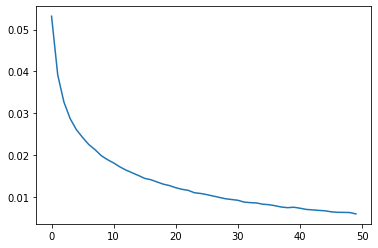

In [22]:
import matplotlib.pyplot as plt

plt.plot(tr_loss)

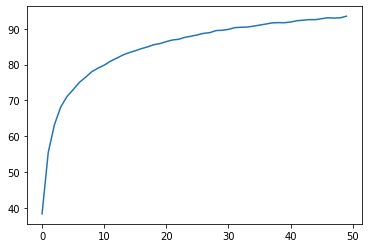

In [23]:
plt.plot(tr_acc)

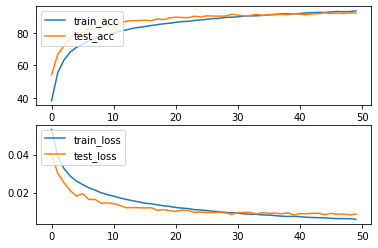

In [26]:
fig = plt.figure()

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


ax1.plot(tr_acc, label="train_acc")
ax1.plot(te_acc, label="test_acc")
ax1.legend(loc=2)
ax2.plot(tr_loss, label="train_loss")
ax2.plot(te_loss, label="test_loss")
ax2.legend(loc=2)
plt.show()

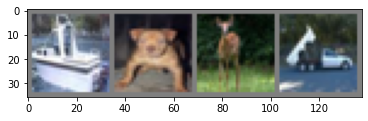

GroundTruth:   ship   dog  deer truck


In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
images = images[:4].to(device)
outputs = net(images)

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   dog  deer truck
